# Data cleaning + EDA 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Storing all necessary df's 

The data was retrieved from the MIMIC-IV dataset, available on PhysioNet: https://physionet.org/content/mimiciv/2.2/  

In [76]:
admissions = pd.read_csv('/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/admissions.csv')
patients = pd.read_csv('/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/patients.csv')
icuStays = pd.read_csv('/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/icu/icustays.csv') # This is what we are interested in --> the stays in ICU
diagnoses = pd.read_csv("/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/diagnoses_icd.csv.gz")
# procedures = pd.read_csv("/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/prescriptions.csv", low_memory=True) --> will be read later due to the size


In [77]:
icuStays.shape

(73181, 8)

In [78]:
# only interested in stays of at least one day
icuStays = icuStays[icuStays['los'] >= 1]

# common hadm_id values between icustays_df and admissions_df
common_hadm_ids = set(icuStays['hadm_id']) & set(admissions['hadm_id'])

#  keep only rows with hadm_id in common_hadm_ids
admissions = admissions[admissions['hadm_id'].isin(common_hadm_ids)]
icuStays = icuStays[icuStays['hadm_id'].isin(common_hadm_ids)]

subjects = set(admissions['subject_id'])
stays = set(icuStays['stay_id'])

In [79]:
print(icuStays.shape)

(57734, 8)


### ICU stays

In [80]:
icuStays.drop(['last_careunit', 'first_careunit'], axis=1, inplace=True)

#### 1. Admissions

In [81]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
39,10001217,24597018,2157-11-18 22:56:00,2157-11-25 18:00:00,NaN,EW EMER.,P4645A,EMERGENCY ROOM,HOME HEALTH CARE,Other,?,MARRIED,WHITE,2157-11-18 17:38:00,2157-11-19 01:24:00,0
58,10001725,25563031,2110-04-11 15:08:00,2110-04-14 15:00:00,NaN,EW EMER.,P35SU0,PACU,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
73,10001884,26184834,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,OBSERVATION ADMIT,P874LG,EMERGENCY ROOM,DIED,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2131-01-07 13:36:00,2131-01-07 22:13:00,1
89,10002013,23581541,2160-05-18 07:45:00,2160-05-23 13:30:00,NaN,SURGICAL SAME DAY ADMISSION,P47E1G,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,OTHER,NaN,NaN,0
103,10002155,23822395,2129-08-04 12:44:00,2129-08-18 16:53:00,NaN,EW EMER.,P05HUO,PROCEDURE SITE,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,MARRIED,WHITE,2129-08-04 11:00:00,2129-08-04 12:35:00,0


In [82]:
admissions.columns

# this df has important columns that could influence the models: 'insurance', 'race', 'marital_status'

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag'],
      dtype='object')

In [83]:
admissions = admissions[admissions['admission_location'] != 'INFORMATION NOT AVAILABLE']

def group_admission_location(icu_name):
    if icu_name == 'EMERGENCY ROOM':
        return 'Emergency'
    elif icu_name in ['PHYSICIAN REFERRAL', 'CLINIC REFERRAL', 'AMBULATORY SURGERY TRANSFER']:
        return 'Referral'
    elif icu_name in ['TRANSFER FROM HOSPITAL', 'TRANSFER FROM SKILLED NURSING FACILITY', 'INTERNAL TRANSFER TO OR FROM PSYCH']:
        return 'Transfer'
    else:
        return 'Other'

admissions['admission_location'] = admissions['admission_location'].apply(group_admission_location)


In [85]:
print(len(admissions['race'].unique()))

print((admissions['race'] == 'UNABLE TO OBTAIN').sum()) # exclude these entries from our analysis
print((admissions['race'] == 'UNKNOWN').sum()) # exclude these entries from our analysis
# 'PATIENT DECLINED TO ANSWER' is this a case i should include/exclude

print(admissions['race'].unique())

# 33 different races, but I will group all hispanics together, same for white, asian

33
633
4752
['WHITE' 'BLACK/AFRICAN AMERICAN' 'OTHER' 'UNKNOWN' 'UNABLE TO OBTAIN'
 'WHITE - RUSSIAN' 'BLACK/CAPE VERDEAN' 'PORTUGUESE'
 'HISPANIC/LATINO - PUERTO RICAN' 'ASIAN - SOUTH EAST ASIAN'
 'WHITE - BRAZILIAN' 'HISPANIC OR LATINO' 'WHITE - OTHER EUROPEAN'
 'BLACK/AFRICAN' 'HISPANIC/LATINO - SALVADORAN' 'ASIAN'
 'PATIENT DECLINED TO ANSWER' 'BLACK/CARIBBEAN ISLAND'
 'HISPANIC/LATINO - DOMINICAN' 'ASIAN - KOREAN' 'ASIAN - CHINESE'
 'ASIAN - ASIAN INDIAN' 'WHITE - EASTERN EUROPEAN'
 'HISPANIC/LATINO - HONDURAN' 'HISPANIC/LATINO - COLUMBIAN'
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'HISPANIC/LATINO - GUATEMALAN' 'AMERICAN INDIAN/ALASKA NATIVE'
 'HISPANIC/LATINO - CENTRAL AMERICAN' 'HISPANIC/LATINO - MEXICAN'
 'SOUTH AMERICAN' 'MULTIPLE RACE/ETHNICITY' 'HISPANIC/LATINO - CUBAN']


In [86]:
# Drop admissions with 'UNABLE TO OBTAIN' or 'UNKNOWN' race
admissions = admissions[~admissions['race'].isin(['UNABLE TO OBTAIN', 'UNKNOWN'])]

# method to group races
def group_race(race):
    if 'WHITE' in race:
        return 'White'
    elif 'BLACK' in race:
        return 'Black/African American'
    elif 'HISPANIC' in race or 'LATINO' in race:
        return 'Hispanic/Latino'
    elif 'ASIAN' in race:
        return 'Asian'
    else:
        return 'Other'

admissions['raceGroup_1'] = admissions['race'].apply(group_race)
print(admissions['raceGroup_1'].value_counts())


White                     35915
Black/African American     5534
Other                      2537
Hispanic/Latino            1961
Asian                      1554
Name: raceGroup_1, dtype: int64


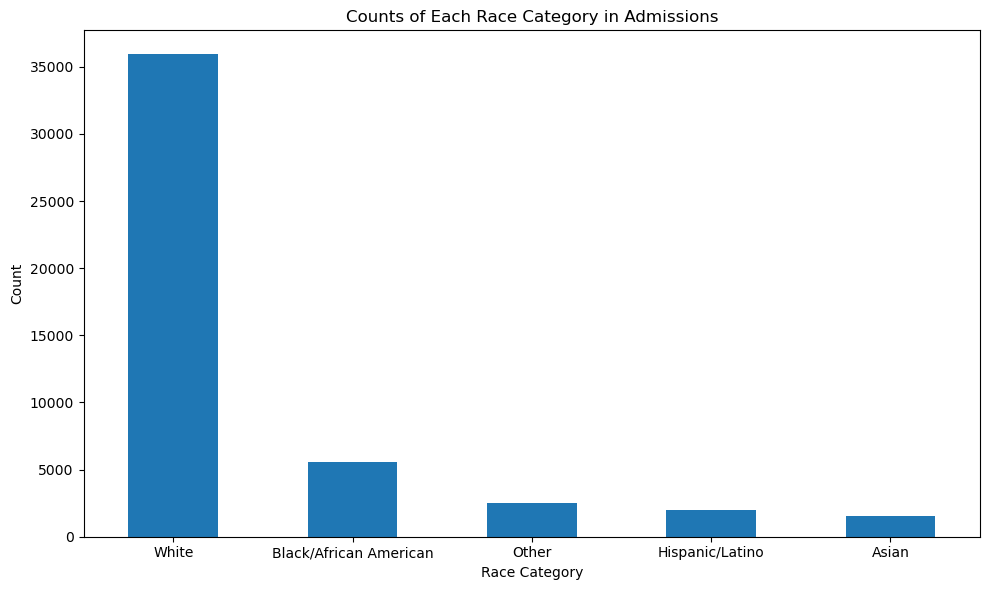

In [46]:
race_counts = admissions['raceGroup_1'].value_counts()

plt.figure(figsize=(10, 6))
race_counts.plot(kind='bar')
plt.title('Counts of Each Race Category in Admissions')
plt.xlabel('Race Category')
plt.ylabel('Count')
plt.xticks(rotation=360)  
plt.tight_layout()
plt.show()

In [87]:
# Also making a second option white/minority to see how it could impact the models
# method to group races
def group_race(race):
    if 'White' in race:
        return 'NonMinority'
    elif 'Black/African American' in race:
        return 'Minority'
    elif 'Hispanic/Latino' in race:
        return 'Minority'
    elif 'Asian' in race:
        return 'Minority'
    else:
        return 'Minority'

admissions['raceGrouped'] = admissions['raceGroup_1'].apply(group_race)
admissions.drop('raceGroup_1', axis=1, inplace=True)
print(admissions['raceGrouped'].value_counts())

NonMinority    35915
Minority       11586
Name: raceGrouped, dtype: int64


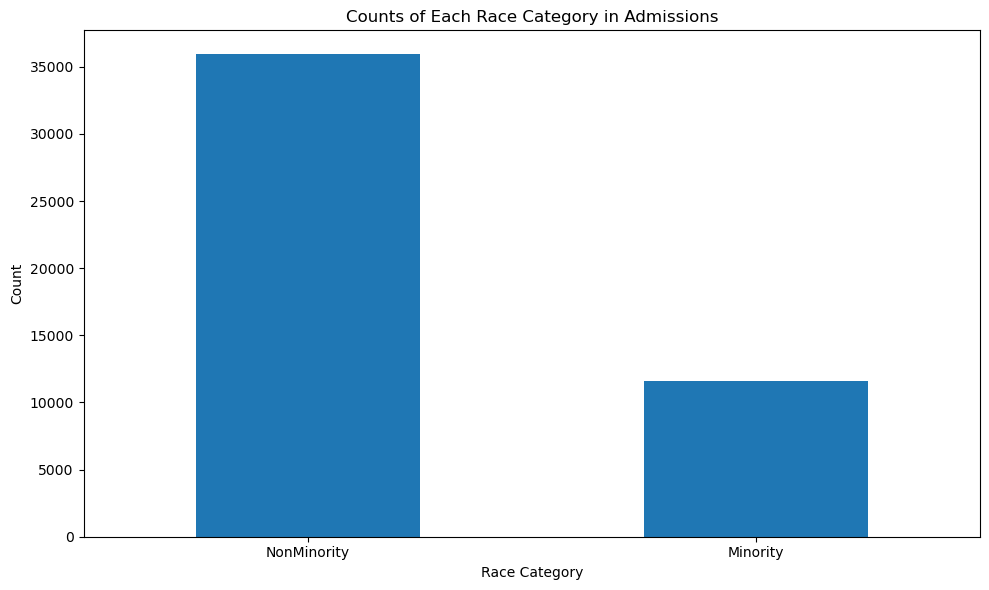

In [10]:
race_counts = admissions['raceGrouped'].value_counts()

plt.figure(figsize=(10, 6))
race_counts.plot(kind='bar')
plt.title('Counts of Each Race Category in Admissions')
plt.xlabel('Race Category')
plt.ylabel('Count')
plt.xticks(rotation=360)  
plt.tight_layout()
plt.show()

In [88]:
# Make gender binary for modelling: Minority=1, NonMinority = 0
admissions['raceGrouped'] = np.array(admissions['raceGrouped'] == 'Minority').astype(int)

In [12]:
len(admissions['insurance'].unique())

3

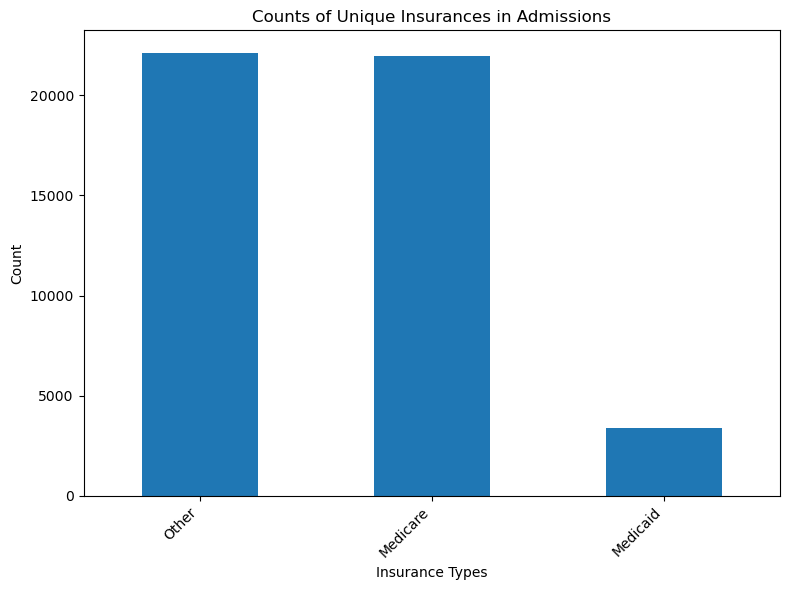

In [16]:
insurance_counts = admissions['insurance'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
insurance_counts.plot(kind='bar')
plt.title('Counts of Unique Insurances in Admissions')
plt.xlabel('Insurance Types')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [52]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,raceGrouped
39,10001217,24597018,2157-11-18 22:56:00,2157-11-25 18:00:00,NaN,EW EMER.,P4645A,Emergency,HOME HEALTH CARE,Other,?,MARRIED,WHITE,2157-11-18 17:38:00,2157-11-19 01:24:00,0,0
58,10001725,25563031,2110-04-11 15:08:00,2110-04-14 15:00:00,NaN,EW EMER.,P35SU0,Other,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0,0
73,10001884,26184834,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,OBSERVATION ADMIT,P874LG,Emergency,DIED,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2131-01-07 13:36:00,2131-01-07 22:13:00,1,1
89,10002013,23581541,2160-05-18 07:45:00,2160-05-23 13:30:00,NaN,SURGICAL SAME DAY ADMISSION,P47E1G,Referral,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,OTHER,NaN,NaN,0,1
103,10002155,23822395,2129-08-04 12:44:00,2129-08-18 16:53:00,NaN,EW EMER.,P05HUO,Other,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,MARRIED,WHITE,2129-08-04 11:00:00,2129-08-04 12:35:00,0,0


In [89]:
icuStays.shape

(57734, 6)

In [101]:
# add 'admission_location' 'insurance' 'raceGroup_2' 'marital_status' to icuStays based on subjectID
icuStays = pd.merge(icuStays, admissions[['subject_id', 'hadm_id', 'admission_location', 'insurance', 'raceGrouped', 'marital_status']],
                    on=['subject_id', 'hadm_id'], how='inner')

icuStays.head()

,subject_id,hadm_id,stay_id,intime,outtime,los,admission_location_x,insurance_x,raceGrouped_x,marital_status_x,admission_location_y,insurance_y,raceGrouped_y,marital_status_y
0,10001217,24597018,37067082,2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,Emergency,Other,0.0,MARRIED,Emergency,Other,0,MARRIED
1,10001725,25563031,31205490,2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,Other,Other,0.0,MARRIED,Other,Other,0,MARRIED
2,10001884,26184834,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,Emergency,Medicare,1.0,MARRIED,Emergency,Medicare,1,MARRIED
3,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,Referral,Medicare,1.0,SINGLE,Referral,Medicare,1,SINGLE
4,10002155,23822395,33685454,2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,Other,Other,0.0,MARRIED,Other,Other,0,MARRIED


#### 2. Patients

In [103]:
patients = patients[patients['subject_id'].isin(subjects)]
patients.head()
# this df has important columns that could influence the models: 'gender' & 'anchor_age'

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
40,10001217,F,55,2157,2011 - 2013,NaN
53,10001725,F,46,2110,2011 - 2013,NaN
61,10001884,F,68,2122,2008 - 2010,2131-01-20
65,10002013,F,53,2156,2008 - 2010,NaN
68,10002155,F,80,2128,2008 - 2010,2131-03-10


Here we have a table of 299712 patients, however from the 'admissions' df we can see that only 180733 were admitted to the ICU, we will only keep the info of those admitted into the ICU for now

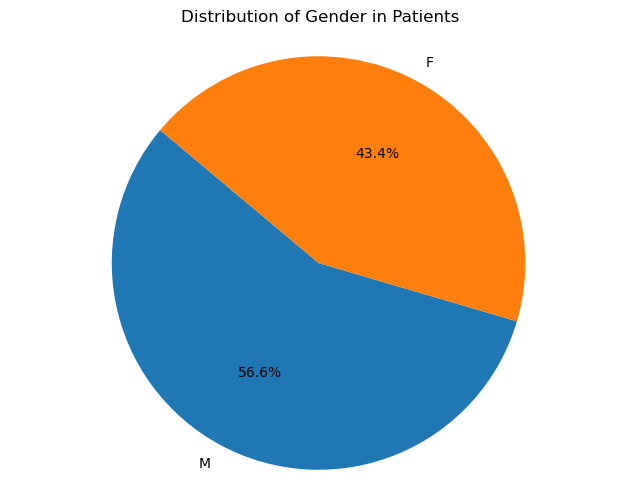

In [15]:
gender = patients['gender'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(gender, labels=gender.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Gender in Patients')
plt.axis('equal')  
plt.show()

In [104]:
# Make gender binary for modelling: Male=1, Female = 0
patients['gender'] = np.array(patients['gender'] == 'M').astype(int)

From the pie chart one can see that there is no drastic imbalance

In [20]:
print("min age: ", patients['anchor_age'].min())
print("max age: ", patients['anchor_age'].max())
print("mean age: ", patients['anchor_age'].mean())

min age:  18
max age:  91
mean age:  63.97113382547795


In [105]:
age_bins = [18, 25, 45, 65, 89, float('inf')]
age_labels = ['18-24', '25-44', '45-64', '65-88', '89+']
patients['age_group'] = pd.cut(patients['anchor_age'], bins=age_bins, labels=age_labels, right=False)

age_group_dummies = pd.get_dummies(patients['age_group'], prefix='age')
patients = pd.concat([patients, age_group_dummies], axis=1)

patients.drop(['anchor_age', 'age_group', 'anchor_year', 'anchor_year_group', 'dod'], axis=1, inplace=True)

patients.head()

,subject_id,gender,age_18-24,age_25-44,age_45-64,age_65-88,age_89+
40,10001217,0,0,0,1,0,0
53,10001725,0,0,0,1,0,0
61,10001884,0,0,0,0,1,0
65,10002013,0,0,0,1,0,0
68,10002155,0,0,0,0,1,0


In [ ]:
icuustay = icuStays.copy()

In [106]:
# add gender and age groups to icustays too based on subjectID

icuStays = pd.merge(icuStays, patients[['subject_id', 'gender','age_18-24','age_25-44','age_45-64','age_65-88','age_89+']],
                    on='subject_id', how='inner')

icuStays.head()

,subject_id,hadm_id,stay_id,intime,outtime,los,admission_location_x,insurance_x,raceGrouped_x,marital_status_x,admission_location_y,insurance_y,raceGrouped_y,marital_status_y,gender,age_18-24,age_25-44,age_45-64,age_65-88,age_89+
0,10001217,24597018,37067082,2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,Emergency,Other,0.0,MARRIED,Emergency,Other,0,MARRIED,0,0,0,1,0,0
1,10001725,25563031,31205490,2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,Other,Other,0.0,MARRIED,Other,Other,0,MARRIED,0,0,0,1,0,0
2,10001884,26184834,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,Emergency,Medicare,1.0,MARRIED,Emergency,Medicare,1,MARRIED,0,0,0,0,1,0
3,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,Referral,Medicare,1.0,SINGLE,Referral,Medicare,1,SINGLE,0,0,0,1,0,0
4,10002155,23822395,33685454,2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,Other,Other,0.0,MARRIED,Other,Other,0,MARRIED,0,0,0,0,1,0


In [107]:
icuStays.shape

(51703, 20)

#### 3. ICUstays

In [18]:
print(icuStays.shape)
icuStays.head()

(97254, 16)


,subject_id,hadm_id,stay_id,intime,outtime,los,admission_location,insurance,raceGrouped,marital_status,gender,age_18-24,age_25-44,age_45-64,age_65-88,age_89+
0,10001217,24597018,37067082,2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,Emergency,Other,0,MARRIED,0,0,0,1,0,0
1,10001725,25563031,31205490,2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,Other,Other,0,MARRIED,0,0,0,1,0,0
2,10001884,26184834,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,Emergency,Medicare,1,MARRIED,0,0,0,0,1,0
3,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,Referral,Medicare,1,SINGLE,0,0,0,1,0,0
4,10002155,23822395,33685454,2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,Other,Other,0,MARRIED,0,0,0,0,1,0


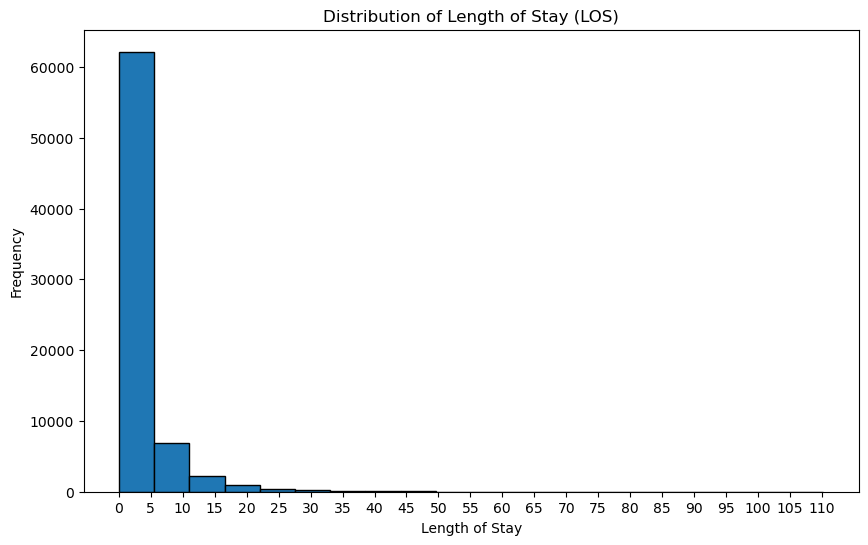

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(icuStays['los'], bins=20, edgecolor='black')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.title('Distribution of Length of Stay (LOS)')
plt.xticks(range(0, int(icuStays['los'].max()) + 1, 5)) 
plt.show()

In [30]:
counts, bin_edges = np.histogram(icuStays['los'], bins=20)

# Bin 4 stops at the 5th bin edge (index 4)
print("Bin 4 stops at:", bin_edges[4])

Bin edges: [1.25000000e-03 5.51280150e+00 1.10243530e+01 1.65359045e+01
 2.20474560e+01 2.75590075e+01 3.30705590e+01 3.85821105e+01
 4.40936620e+01 4.96052135e+01 5.51167650e+01 6.06283166e+01
 6.61398681e+01 7.16514196e+01 7.71629711e+01 8.26745226e+01
 8.81860741e+01 9.36976256e+01 9.92091771e+01 1.04720729e+02
 1.10232280e+02]
Bin 4 stops at: 22.04745601851852


In [109]:
icuStays = icuStays[icuStays['los'] <=22]
print(icuStays.shape)

(50881, 20)


In [32]:
los_descripStats = icuStays['los'].describe()

print("Descriptive statistics for los:")
print(los_descripStats)

Descriptive statistics for los:
count    72191.000000
mean         3.057368
std          3.344105
min          0.001250
25%          1.077639
50%          1.903796
75%          3.573646
max         21.999653
Name: los, dtype: float64


Average LOS in ICU is around 4 days. We can also see that the 75% quantile has value 4.43, so this shows that most stays are under 4 days. Only 25% is above 4.43 days

##### Outlier analysis of the dependent variable 'los'

In [18]:
# Outlier analysis using IQR + visualising with boxplot

Q1 = icuStays['los'].quantile(0.25)
Q3 = icuStays['los'].quantile(0.75)
IQR = Q3 - Q1

LB = Q1 - 1.5 * IQR
UB = Q3 + 1.5 * IQR

print("Lower bound:", LB)
print("Upper bound:", UB)

Lower bound: -2.725580150462963
Upper bound: 8.732047164351851


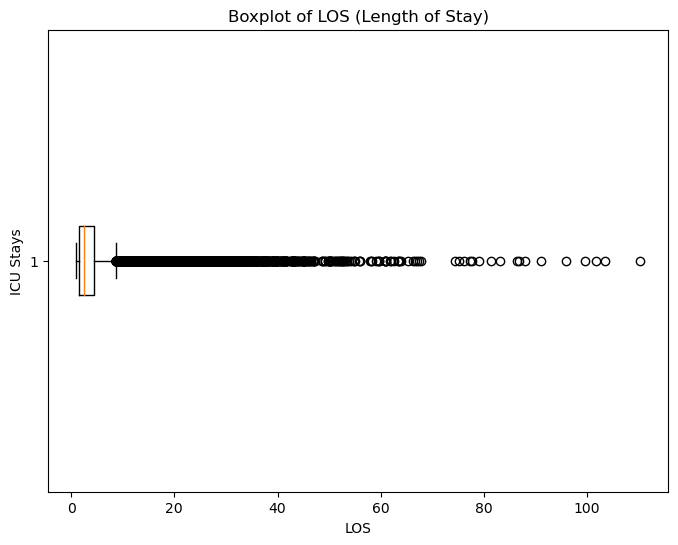

In [19]:
plt.figure(figsize=(8, 6))
plt.boxplot(icuStays['los'], vert=False)
plt.title('Boxplot of LOS (Length of Stay)')
plt.xlabel('LOS')
plt.ylabel('ICU Stays')
plt.show()

In [20]:
aboveUB = (len(icuStays[icuStays['los'] > UB]) / len(icuStays)) * 100
print("% of stays above Upper bound:", aboveUB)

% of stays above Upper bound: 10.266047736169329


In [33]:
aboveUB = icuStays[icuStays['los'] > UB]
plt.figure(figsize=(10, 6))
plt.hist(aboveUB['los'], bins=10, edgecolor='black')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.title('Distribution of Length of Stay (LOS) > {}'.format(UB))
plt.grid(True)
plt.show()

NameError: name 'UB' is not defined

In [22]:
hist, bin_edges = np.histogram(aboveUB['los'], bins=10)
print("where the 5th bin starts:", bin_edges[3])
print("Stays in 4th bin: ", len(aboveUB[aboveUB['los'] > 40]))

where the 5th bin starts: 39.18347106481482
Stays in 4th bin:  163


**Comment:** From the histogram we can see that stays above 39 days are very unlikely these will be dropped and considered as outliers

#### 4. Diagnoses

In [19]:
diagnoses = diagnoses[diagnoses['hadm_id'].isin(common_hadm_ids)]
diagnoses_original = diagnoses.copy() # we'll use this later

print(diagnoses.shape)
diagnoses.head()

(948064, 5)


,subject_id,hadm_id,seq_num,icd_code,icd_version
409,10001217,24597018,1,3240,9
410,10001217,24597018,2,3484,9
411,10001217,24597018,3,3485,9
412,10001217,24597018,4,5180,9
413,10001217,24597018,5,340,9


In [25]:
print(diagnoses['icd_version'].unique())

print((diagnoses['icd_version'] == 9).sum()/len(diagnoses))
print((diagnoses['icd_version'] == 10).sum()/len(diagnoses))


# we have 2 different icd_versions so we will transform version icd_9 to icd_10

[ 9 10]
0.5472025095352212
0.45279749046477874


There are 2 different version of ICD codes in the datset, namely 9 (58% of data) and 10 (42% of data). The following website, https://www.cdc.gov/nchs/icd/icd10cm_pcs_background.htm#:~:text=Code%20set%20differences,categories%20instead%20of%20numeric%20ones, states that ICD-9 codes are very different than ICD-10 code set. Therfore, the icd 9 code will be transformed into icd10.  It also says the followig: there are nearly 5 times as many diagnosis codes in ICD-10-CM than in ICD-9-CM. ICD-10 has alphanumeric categories instead of numeric ones.

The model needs to ensure consistency in how it interprets and processes the diagnosis codes.the model must handle them appropriately to avoid misinterpretation or errors in predictions.

In [26]:
# mapping retrieved from: https://www.nber.org/research/data/icd-9-cm-and-icd-10-cm-and-icd-10-pcs-crosswalk-or-general-equivalence-mappings 
mapping = pd.read_csv("/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/icd9toicd10Mapping.csv")
mapping.head()

,icd9cm,icd10cm,flags,approximate,no_map,combination,scenario,choice_list
0,0010,A000,0,0,0,0,0,0
1,0011,A001,0,0,0,0,0,0
2,0019,A009,0,0,0,0,0,0
3,0020,A0100,10000,1,0,0,0,0
4,0021,A011,0,0,0,0,0,0


In [27]:
# Dictionary to map ICD-9 codes to ICD-10 codes
icd9_to_icd10 = dict(zip(mapping['icd9cm'], mapping['icd10cm']))
# new column with icd10 only 
diagnoses['icd10'] = diagnoses['icd_code'].map(icd9_to_icd10).fillna(diagnoses['icd_code'])

diagnoses

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd10
409,10001217,24597018,1,3240,9,G060
410,10001217,24597018,2,3484,9,G935
411,10001217,24597018,3,3485,9,G936
412,10001217,24597018,4,5180,9,J9819
413,10001217,24597018,5,340,9,G35
...,...,...,...,...,...,...
4756321,19999987,23865745,7,41401,9,I2510
4756322,19999987,23865745,8,78039,9,R569
4756323,19999987,23865745,9,0413,9,B961
4756324,19999987,23865745,10,36846,9,H53469


In [28]:
def map_icd_to_category(icd10_code):
    # These are the orignal names we will justw work with the chapter names
    icd_category_map = {
        'A00–B99': 'Infections',
        'C00–D48': 'Neoplasms',
        'D50–D89': 'Blood',
        'E00–E90': 'Endocrine',
        'F00–F99': 'Mental',
        'G00–G99': 'Nervous',
        'H00–H59': 'Eye',
        'H60–H95': 'Ear',
        'I00–I99': 'Circulatory',
        'J00–J99': 'Respiratory',
        'K00–K93': 'Digestive',
        'L00–L99': 'Skin',
        'M00–M99': 'Musculoskeletal',
        'N00–N99': 'Genitourinary',
        'O00–O99': 'Pregnancy',
        'P00–P96': 'Perinatal',
        'Q00–Q99': 'Congenital',
        'R00–R99': 'Symptoms',
        'S00–T98': 'Injury',
        'V01–Y98': 'External',
        'Z00–Z99': 'Health',
        'U00–U99': 'Special'
    }

    for key in icd_category_map:
        if key.split("–")[0] <= icd10_code <= key.split("–")[1]:
            return icd_category_map[key]
    return None

# Map the ICD-10 codes to categories and create the new 'category' column
diagnoses['category'] = diagnoses['icd10'].apply(map_icd_to_category)

In [29]:
diagnoses.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd10,category
409,10001217,24597018,1,3240,9,G060,Nervous
410,10001217,24597018,2,3484,9,G935,Nervous
411,10001217,24597018,3,3485,9,G936,Nervous
412,10001217,24597018,4,5180,9,J9819,Respiratory
413,10001217,24597018,5,340,9,G35,Nervous


In [30]:
# Drop columns seq_num, icd_code, and icd_version
diagnoses.drop(['seq_num', 'icd_code', 'icd_version'], axis=1, inplace=True)

# Create dummy variables for chapter
dummy_vars = pd.get_dummies(diagnoses['category'])

# Concatenate with the original DataFrame
diagnoses = pd.concat([diagnoses, dummy_vars], axis=1)
diagnoses.head()

,subject_id,hadm_id,icd10,category,Blood,Circulatory,Congenital,Digestive,Ear,Endocrine,...,Injury,Mental,Musculoskeletal,Neoplasms,Nervous,Perinatal,Pregnancy,Respiratory,Skin,Symptoms
409,10001217,24597018,G060,Nervous,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
410,10001217,24597018,G935,Nervous,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
411,10001217,24597018,G936,Nervous,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
412,10001217,24597018,J9819,Respiratory,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
413,10001217,24597018,G35,Nervous,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [31]:
diagnoses = diagnoses.groupby('hadm_id').sum().reset_index()
diagnoses.head()

,hadm_id,subject_id,Blood,Circulatory,Congenital,Digestive,Ear,Endocrine,External,Eye,...,Injury,Mental,Musculoskeletal,Neoplasms,Nervous,Perinatal,Pregnancy,Respiratory,Skin,Symptoms
0,20000147,269824032,0,5,0,1,0,5,0,0,...,0,1,2,0,1,0,0,0,0,0
1,20000808,117521243,0,1,0,1,0,0,0,0,...,0,2,0,1,2,0,0,0,0,0
2,20001305,496113491,1,2,0,0,0,1,4,0,...,3,1,1,2,1,0,0,4,0,2
3,20001361,160353237,0,1,0,1,0,1,0,0,...,0,2,1,0,1,0,0,2,0,1
4,20001494,207676833,0,2,0,1,0,0,2,0,...,0,1,0,2,0,0,0,0,0,1


In [43]:
diagnoses.columns

Index(['hadm_id', 'subject_id', 'Blood', 'Circulatory', 'Congenital',
       'Digestive', 'Ear', 'Endocrine', 'External', 'Eye', 'Genitourinary',
       'Health', 'Infections', 'Injury', 'Mental', 'Musculoskeletal',
       'Neoplasms', 'Nervous', 'Perinatal', 'Pregnancy', 'Respiratory', 'Skin',
       'Symptoms'],
      dtype='object')

In [62]:
diagnoses.to_csv('diag.csv', index=False)

In [44]:
# Since a patient can have multiple diagnoses for the prediction we will keep track of how many diagnoses a patient has
diagnoses_count = diagnoses_original.groupby(['hadm_id']).size().reset_index(name='diagnoses_num')
diagnoses_count.head()

,hadm_id,diagnoses_num
0,20000147,18
1,20000808,7
2,20001305,31
3,20001361,11
4,20001494,13


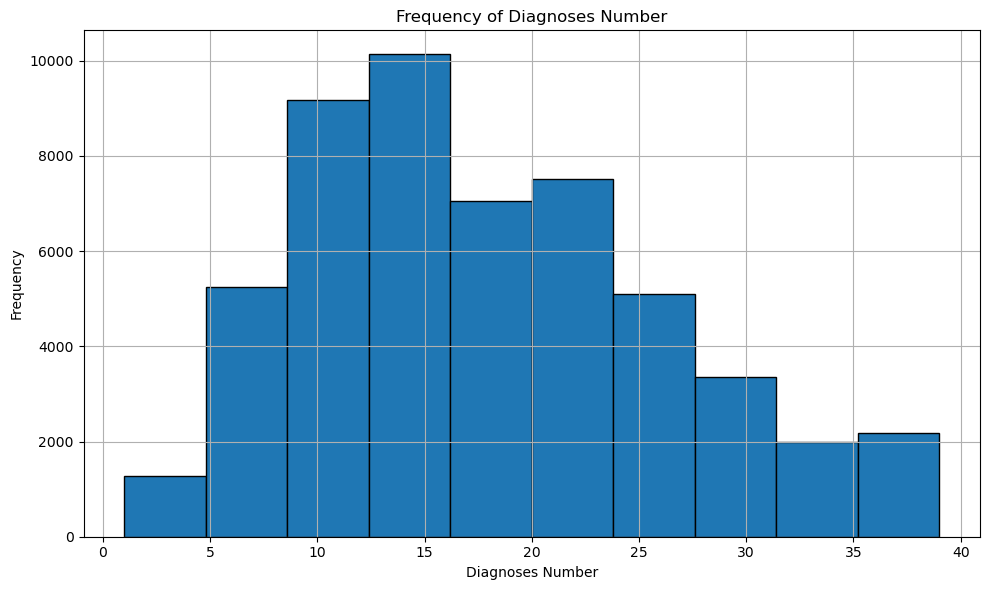

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(diagnoses_count['diagnoses_num'], bins=10, edgecolor='black')
plt.xlabel('Diagnoses Number')
plt.ylabel('Frequency')
plt.title('Frequency of Diagnoses Number')
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
diagnoses_num_stats = diagnoses_count['diagnoses_num'].describe()
print(diagnoses_num_stats)


count    430852.000000
mean         11.039350
std           7.282404
min           1.000000
25%           5.000000
50%          10.000000
75%          15.000000
max          57.000000
Name: diagnoses_num, dtype: float64


In [49]:
diagnoses.head()

,hadm_id,subject_id,Blood,Circulatory,Congenital,Digestive,Ear,Endocrine,External,Eye,...,Injury,Mental,Musculoskeletal,Neoplasms,Nervous,Perinatal,Pregnancy,Respiratory,Skin,Symptoms
0,20000147,269824032,0,5,0,1,0,5,0,0,...,0,1,2,0,1,0,0,0,0,0
1,20000808,117521243,0,1,0,1,0,0,0,0,...,0,2,0,1,2,0,0,0,0,0
2,20001305,496113491,1,2,0,0,0,1,4,0,...,3,1,1,2,1,0,0,4,0,2
3,20001361,160353237,0,1,0,1,0,1,0,0,...,0,2,1,0,1,0,0,2,0,1
4,20001494,207676833,0,2,0,1,0,0,2,0,...,0,1,0,2,0,0,0,0,0,1


In [32]:
icu = icuStays.copy()

In [34]:
# # merge diagnoses_num and diagnoses groups to icuStays based of hadm_id
# icu = pd.merge(icuStays, diagnoses[['subject_id', 'hadm_id', 'Blood', 'Circulatory', 'Congenital',
#        'Digestive', 'Ear', 'Endocrine', 'External', 'Eye', 'Genitourinary',
#        'Health', 'Infections', 'Injury', 'Mental', 'Musculoskeletal',
#        'Neoplasms', 'Nervous', 'Perinatal', 'Pregnancy', 'Respiratory', 'Skin',
#        'Symptoms']],
#             left_on=['subject_id', 'hadm_id'],
#             right_on=['subject_id', 'hadm_id'], how='inner')

# icu.head()

# not many in common so we will drop diganoses for the analysis

,subject_id,hadm_id,stay_id,intime,los,admission_location,insurance,raceGrouped,marital_status,gender,...,Injury,Mental,Musculoskeletal,Neoplasms,Nervous,Perinatal,Pregnancy,Respiratory,Skin,Symptoms
0,10195266,24940729,36629096,2166-10-20 19:39:00,1.038623,Emergency,Medicaid,1,SINGLE,0,...,0,0,0,0,0,0,0,0,0,0
1,10195266,24940729,36629096,2166-10-20 19:39:00,1.038623,Emergency,Medicaid,1,SINGLE,0,...,0,0,0,0,0,0,0,0,0,0
2,10435225,21805406,39207665,2186-08-26 03:16:00,1.402928,Emergency,Other,0,MARRIED,0,...,0,0,1,0,0,0,0,0,0,0
3,10486503,24479380,34105807,2162-02-24 12:41:51,1.063044,Referral,Other,1,MARRIED,0,...,0,0,0,0,0,0,0,0,0,0
4,10791103,21723959,35141200,2151-05-15 04:48:00,1.709688,Emergency,Medicaid,1,SINGLE,1,...,0,0,0,0,0,0,0,0,0,0


#### 5. Prescriptions

In [16]:
file_path = '/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/prescriptions.csv'

In [21]:
icuu = icuStays[['subject_id', 'hadm_id', 'intime', 'outtime']].copy()
icuu.head()

,subject_id,hadm_id,intime,outtime
0,10001217,24597018,2157-11-20 19:18:02,2157-11-21 22:08:00
1,10001725,25563031,2110-04-11 15:52:22,2110-04-12 23:59:56
2,10001884,26184834,2131-01-11 04:20:05,2131-01-20 08:27:30
3,10002013,23581541,2160-05-18 10:00:53,2160-05-19 17:33:33
4,10002155,23822395,2129-08-04 12:45:00,2129-08-10 17:02:38


In [18]:
chunk_size = 5000 
chunks = []

icuu['intime'] = pd.to_datetime(icuu['intime'])
icuu['outtime'] = pd.to_datetime(icuu['outtime'])

# Read the file in chunks
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    chunk['starttime'] = pd.to_datetime(chunk['starttime'])
    chunk['stoptime'] = pd.to_datetime(chunk['stoptime'])
    
    # Merge the chunk with the ICU stays DataFrame to get the 'intime' and 'outtime' for each stay
    merged_chunk = pd.merge(
        chunk,
        icuu[['subject_id', 'hadm_id','intime', 'outtime']],
        how='inner',
        left_on=['subject_id', 'hadm_id'],
        right_on=['subject_id', 'hadm_id']
    )
    
    # Filter rows where 'starttime' is between 'intime' and 'outtime'
    condition = (merged_chunk['starttime'] >= merged_chunk['intime']) & (merged_chunk['starttime'] <= merged_chunk['outtime'])
    filtered_chunk = merged_chunk[condition]
    
    # Keep only the specified columns
    filtered_chunk = filtered_chunk[['drug', 'subject_id', 'hadm_id', 'starttime', 'stoptime']]
    
    # Append the filtered chunk to the list
    chunks.append(filtered_chunk)

# Concatenate all processed chunks into a single DataFrame
prescriptions_df = pd.concat(chunks, ignore_index=True)

prescriptions_df.head()


,drug,subject_id,hadm_id,starttime,stoptime
0,Ondansetron,10001217,24597018,2157-11-21 08:00:00,2157-11-25 22:00:00
1,Heparin,10001217,24597018,2157-11-21 08:00:00,2157-11-25 22:00:00
2,Heparin Flush (10 units/ml),10001217,24597018,2157-11-21 15:00:00,2157-11-21 23:00:00
3,Sodium Chloride 0.9% Flush,10001217,24597018,2157-11-21 15:00:00,2157-11-21 23:00:00
4,Acetaminophen IV,10001217,24597018,2157-11-21 20:00:00,2157-11-21 23:00:00


In [19]:
# Convert to datetime
icuu['intime'] = pd.to_datetime(icuu['intime'])
icuu['outtime'] = pd.to_datetime(icuu['outtime'])
prescriptions_df['starttime'] = pd.to_datetime(prescriptions_df['starttime'])
prescriptions_df['stoptime'] = pd.to_datetime(prescriptions_df['stoptime'])

print("Before merging, prescriptions_df shape:", prescriptions_df.shape)

# Merge prescriptions with ICU stays
merged_df = pd.merge(
    prescriptions_df,
    icuu[['subject_id', 'hadm_id', 'intime']],
    on=['subject_id', 'hadm_id']
)

# Calculate the 24-hour window from the 'intime'
merged_df['24hr_window'] = merged_df['intime'] + pd.Timedelta(hours=24)

# Filter the prescriptions to only include those within the first 24 hours of ICU stay
prescriptions_df = merged_df[merged_df['starttime'] <= merged_df['24hr_window']]

print("After filtering, filtered_prescriptions_df shape:", prescriptions_df.shape)

# Keep only the specified columns
prescriptions_df = prescriptions_df[['drug', 'subject_id', 'hadm_id']]

prescriptions_df.head()

Before merging, prescriptions_df shape: (5627996, 5)
After filtering, filtered_prescriptions_df shape: (16860495, 7)


,drug,subject_id,hadm_id
0,Ondansetron,10001217,24597018
1,Heparin,10001217,24597018
2,Heparin Flush (10 units/ml),10001217,24597018
3,Sodium Chloride 0.9% Flush,10001217,24597018
5,Lidocaine 1%,10001217,24597018


In [20]:
# pivot table for drugs

prescriptions_df['druggs'] = 1
prescriptions_df = prescriptions_df.pivot_table(index=['subject_id', 'hadm_id'], columns='drug', values='druggs', fill_value=0)

prescriptions_df.reset_index(inplace=True)

In [21]:
print(prescriptions_df.shape)
prescriptions_df.head()

(47001, 2730)


drug,subject_id,hadm_id,(0.9% NaCl),*NF* Abatacept,*NF* Allopurinol Sodium,*NF* Bicalutamide,*NF* Erlotinib,*NF* Ertapenem Sodium,*NF* Imatinib Mesylate,*NF* Levalbuterol Soln,...,vilazodone,vitamin D3,vitamin d3,voriconazole,xalatan,zafirlukast,zinc oxide,zonisamide,zydis,zz
0,10001217,24597018,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001725,25563031,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001884,26184834,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10002013,23581541,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10002155,23822395,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# List of drug columns (assuming all columns after 'hadm_id' are drug columns)
drug_columns = prescriptions_df.columns[2:]

# Calculate the prescrip_count by summing across the drug columns
prescriptions_df['prescrip_count'] = prescriptions_df[drug_columns].sum(axis=1)
prescriptions_df.head(1)

drug,subject_id,hadm_id,(0.9% NaCl),*NF* Abatacept,*NF* Allopurinol Sodium,*NF* Bicalutamide,*NF* Erlotinib,*NF* Ertapenem Sodium,*NF* Imatinib Mesylate,*NF* Levalbuterol Soln,...,vitamin D3,vitamin d3,voriconazole,xalatan,zafirlukast,zinc oxide,zonisamide,zydis,zz,prescrip_count
0,10001217,24597018,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [93]:
prescriptions_df.to_csv('prescriptions.csv', index=False)

#### 6. Lab events

chosen lab predictors based of lit: https://www.mdpi.com/2076-3417/13/12/6930 

In [4]:
lab_codes = pd.read_csv("/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/d_labitems.csv.gz")
lab_codes.head()

,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas


In [5]:
# item IDs of chosen features of lit
item_ids = [220045, 50817, 220210, 50825, 220739, 223900, 223901,
            50868, 50882, 50902, 50912, 50931, 50983, 50960, 50971,
            50970, 51006, 51221, 51222, 51250, 51248, 51249, 51277,
            51279, 51300, 51265]

filtered = lab_codes[lab_codes['itemid'].isin(item_ids)]
filtered.head()

,itemid,label,fluid,category
15,50817,Oxygen Saturation,Blood,Blood Gas
23,50825,Temperature,Blood,Blood Gas
66,50868,Anion Gap,Blood,Chemistry
80,50882,Bicarbonate,Blood,Chemistry
100,50902,Chloride,Blood,Chemistry


In [6]:
file_path = "/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/labevents.csv.gz"

In [22]:
chunks = []
chunk_size = 5000

# Iterate over chunks of lab events data
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Filter chunk based on item_ids
    filtered_chunk = chunk[chunk['itemid'].isin(item_ids)]
    
    # Merge filtered chunk with icuu DataFrame on subject_id
    merged_chunk = pd.merge(filtered_chunk, icuu, on="subject_id", how="inner")
    
    # Convert charttime to datetime
    merged_chunk['charttime'] = pd.to_datetime(merged_chunk['charttime'])
    
    # Filter rows where charttime is within intime and outtime
    filtered_chunk = merged_chunk[(merged_chunk['charttime'] >= pd.to_datetime(merged_chunk['intime'])) & 
                                  (merged_chunk['charttime'] < pd.to_datetime(merged_chunk['outtime']))]
    
    # Keep only necessary columns
    filtered_chunk = filtered_chunk[['subject_id', 'intime','outtime','itemid', 'valuenum', 'charttime']]
    
    # Append filtered chunk to list
    chunks.append(filtered_chunk)

# Concatenate filtered chunks into a single DataFrame
labevents_df = pd.concat(chunks)
labevents_df.reset_index(drop=True, inplace=True)

print(labevents_df.shape)

# Display the first few rows of the filtered labevents DataFrame
labevents_df.head()


(10438026, 6)


,subject_id,intime,outtime,itemid,valuenum,charttime
0,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50868,15.0,2157-11-21 03:16:00
1,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50882,23.0,2157-11-21 03:16:00
2,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50902,104.0,2157-11-21 03:16:00
3,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50912,0.4,2157-11-21 03:16:00
4,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50931,113.0,2157-11-21 03:16:00


In [23]:
# now we will ectract the values of these stuff from the labevents data set --> 24h only
print(labevents_df.shape)
labevents_df['intime'] = pd.to_datetime(labevents_df['intime'])

# Calculate the end time for the 24-hour window
labevents_df['24hr_window'] = labevents_df['intime'] + pd.Timedelta(hours=24)
filtered_labevents_df = labevents_df[labevents_df['charttime'] <= labevents_df['24hr_window']]

# Drop the '24hr_window' column if it's not needed anymore
filtered_labevents_df.drop(columns=['24hr_window'], inplace=True)
labevents_df = filtered_labevents_df

print(labevents_df.shape)
labevents_df.head()


(10438026, 6)
(3683876, 6)


/var/folders/8m/xsxvn0ns46dg_dpnlhpkxk6r0000gn/T/ipykernel_23255/2426701763.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_labevents_df.drop(columns=['24hr_window'], inplace=True)


,subject_id,intime,outtime,itemid,valuenum,charttime
0,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50868,15.0,2157-11-21 03:16:00
1,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50882,23.0,2157-11-21 03:16:00
2,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50902,104.0,2157-11-21 03:16:00
3,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50912,0.4,2157-11-21 03:16:00
4,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50931,113.0,2157-11-21 03:16:00


In [24]:
# add hadm_id to labevents_df
labevents_df['intime'] = pd.to_datetime(labevents_df['intime'])
icuStays['intime'] = pd.to_datetime(icuStays['intime'])

merged_df = pd.merge(labevents_df, icuStays[['subject_id', 'hadm_id', 'intime']], on=['subject_id', 'intime'], how='inner')

labevents_df = merged_df[(merged_df['subject_id'] == merged_df['subject_id']) & 
                                   (merged_df['itemid'] == merged_df['itemid'])]

print(labevents_df.shape)
labevents_df.head()

(15318366, 7)


,subject_id,intime,outtime,itemid,valuenum,charttime,hadm_id
0,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50868,15.0,2157-11-21 03:16:00,24597018
1,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50882,23.0,2157-11-21 03:16:00,24597018
2,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50902,104.0,2157-11-21 03:16:00,24597018
3,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50912,0.4,2157-11-21 03:16:00,24597018
4,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,50931,113.0,2157-11-21 03:16:00,24597018


In [25]:
itemid_to_label = dict(zip(filtered['itemid'], filtered['label']))

# Replace the values in the "itemid" column with their corresponding labels
labevents_df['itemid'] = labevents_df['itemid'].map(itemid_to_label)

,subject_id,intime,outtime,itemid,valuenum,charttime,hadm_id
0,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,Anion Gap,15.00,2157-11-21 03:16:00,24597018
1,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,Bicarbonate,23.00,2157-11-21 03:16:00,24597018
2,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,Chloride,104.00,2157-11-21 03:16:00,24597018
3,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,Creatinine,0.40,2157-11-21 03:16:00,24597018
4,10001217,2157-11-20 19:18:02,2157-11-21 22:08:00,Glucose,113.00,2157-11-21 03:16:00,24597018
...,...,...,...,...,...,...,...
15318361,19999840,2164-09-12 09:26:28,2164-09-17 16:35:15,RDW,14.30,2164-09-13 01:51:00,21033226
15318362,19999840,2164-09-12 09:26:28,2164-09-17 16:35:15,Red Blood Cells,4.09,2164-09-13 01:51:00,21033226
15318363,19999840,2164-09-12 09:26:28,2164-09-17 16:35:15,Magnesium,2.10,2164-09-13 08:49:00,21033226
15318364,19999840,2164-09-12 09:26:28,2164-09-17 16:35:15,Phosphate,2.60,2164-09-13 08:49:00,21033226


In [26]:
# further clean again
labevents_df = labevents_df[['subject_id', 'hadm_id', 'itemid', 'valuenum']]
labevents_df.head()

,subject_id,hadm_id,itemid,valuenum
0,10001217,24597018,Anion Gap,15.0
1,10001217,24597018,Bicarbonate,23.0
2,10001217,24597018,Chloride,104.0
3,10001217,24597018,Creatinine,0.4
4,10001217,24597018,Glucose,113.0


In [27]:
# Create the pivot table
labevents_df = labevents_df.pivot_table(
    index=['subject_id', 'hadm_id'], 
    columns='itemid', 
    values='valuenum', 
    aggfunc='first'
).reset_index()

# Flatten the column hierarchy created by pivot_table
labevents_df.columns.name = None
labevents_df.columns = [str(col) for col in labevents_df.columns]

labevents_df.head()


,subject_id,hadm_id,Anion Gap,Bicarbonate,Chloride,Creatinine,Glucose,Hematocrit,Hemoglobin,MCH,...,Oxygen Saturation,Phosphate,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Temperature,Urea Nitrogen,WBC Count
0,10001217,24597018,15.0,23.0,104.0,0.4,113.0,33.6,11.2,27.5,...,NaN,3.2,285.0,3.6,14.1,4.05,138.0,NaN,9.0,NaN
1,10001725,25563031,14.0,24.0,106.0,0.8,146.0,39.1,13.9,32.2,...,NaN,3.1,330.0,3.9,11.8,4.33,140.0,NaN,16.0,NaN
2,10001884,26184834,11.0,33.0,96.0,1.1,148.0,36.0,11.4,28.4,...,81.0,3.8,171.0,4.0,17.8,4.01,136.0,36.1,30.0,NaN
3,10002013,23581541,12.0,23.0,109.0,1.1,98.0,28.6,10.2,34.8,...,99.0,NaN,252.0,4.0,13.0,2.95,140.0,NaN,16.0,NaN
4,10002155,23822395,13.0,25.0,106.0,0.9,95.0,37.9,12.5,29.7,...,94.0,3.9,185.0,4.5,15.2,4.19,139.0,NaN,19.0,NaN


In [29]:
print(labevents_df.shape)
print(labevents_df.isna().sum())

# will delete Oxygen Saturation, Temperature, WBC Count since there is a lot missing


(46613, 23)
subject_id               0
hadm_id                  0
Anion Gap              221
Bicarbonate            169
Chloride               147
Creatinine             163
Glucose                355
Hematocrit             307
Hemoglobin             397
MCH                    407
MCHC                   406
MCV                    401
Magnesium             1884
Oxygen Saturation    32884
Phosphate             3917
Platelet Count         387
Potassium              183
RDW                    420
Red Blood Cells        400
Sodium                 150
Temperature          36711
Urea Nitrogen          170
WBC Count            46475
dtype: int64


In [30]:
labevents_df.drop(['Oxygen Saturation', 'Temperature', 'WBC Count'], axis=1, inplace=True)
labevents_df.to_csv('labevents.csv', index=False)

In [110]:
icuStays.to_csv('icuStays.csv', index=False)

#### 5. other personal info

In [118]:
personal = pd.read_csv("/Users/ashademeij/Downloads/Thesis/mimic-iv-2.2/hosp/omr.csv.gz")
print(personal.shape)

# list of data types we want to keep
interesting_columns = ['Weight (Lbs)', 'BMI (kg/m2)', 'Height (Inches)']
# Drop the other stuff we are not interested in
personal['result_name'] = np.where(personal['result_name'].isin(interesting_columns), personal['result_name'], 'NA')
personal = personal[personal['result_name'] != 'NA']

personal = personal[personal['seq_num'] == 1]
personal.drop('seq_num', axis=1, inplace=True)

print(personal.shape)
print(personal['result_name'].unique())
personal.head()


(6439169, 5)
(4114663, 4)
['Weight (Lbs)' 'BMI (kg/m2)' 'Height (Inches)']


,subject_id,chartdate,result_name,result_value
1,10000032,2180-04-27,Weight (Lbs),94
2,10000032,2180-05-07,BMI (kg/m2),18.0
3,10000032,2180-05-07,Height (Inches),60
4,10000032,2180-05-07,Weight (Lbs),92.15
22,10000032,2180-05-25,BMI (kg/m2),18.6


In [119]:
# Pivot the DataFrame
personal = personal.pivot_table(index=['subject_id', 'chartdate'], columns='result_name', values='result_value', aggfunc='last').reset_index()
personal.columns.name = None

personal.head()

,subject_id,chartdate,BMI (kg/m2),Height (Inches),Weight (Lbs)
0,10000032,2180-04-27,NaN,NaN,94
1,10000032,2180-05-07,18.0,60,92.15
2,10000032,2180-05-25,18.6,NaN,95
3,10000032,2180-06-01,18.7,NaN,95.7
4,10000032,2180-06-22,18.9,60,97


### LOS EDA based on demographic attributes

### 1. Gender-based

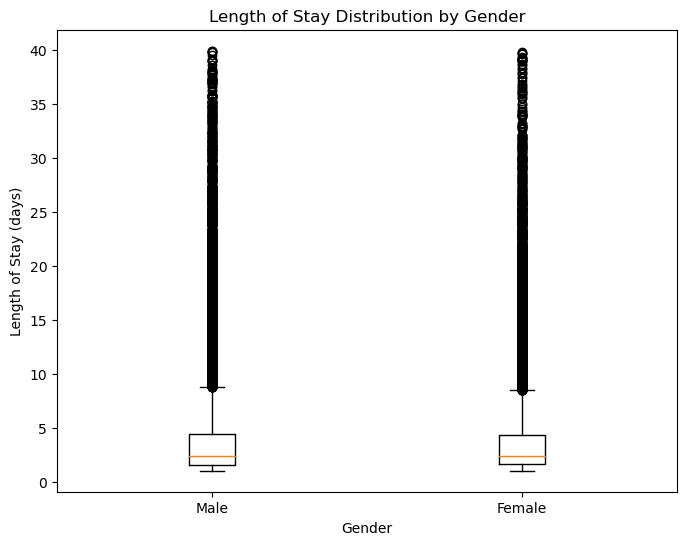

In [93]:
male_los = icuStays.loc[icuStays['subject_id'].isin(patients.loc[patients['gender'] == 'M', 'subject_id']), 'los']
female_los = icuStays.loc[icuStays['subject_id'].isin(patients.loc[patients['gender'] == 'F', 'subject_id']), 'los']

plt.figure(figsize=(8, 6))
plt.boxplot([male_los, female_los], labels=['Male', 'Female'])
plt.title('Length of Stay Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Length of Stay (days)')
plt.show()

In [94]:
male_median = np.median(male_los)
female_median = np.median(female_los)

print("Male:", male_median)
print("Female:", female_median)

Male: 2.391267361111111
Female: 2.407106481481481


### 2. Insurance-based

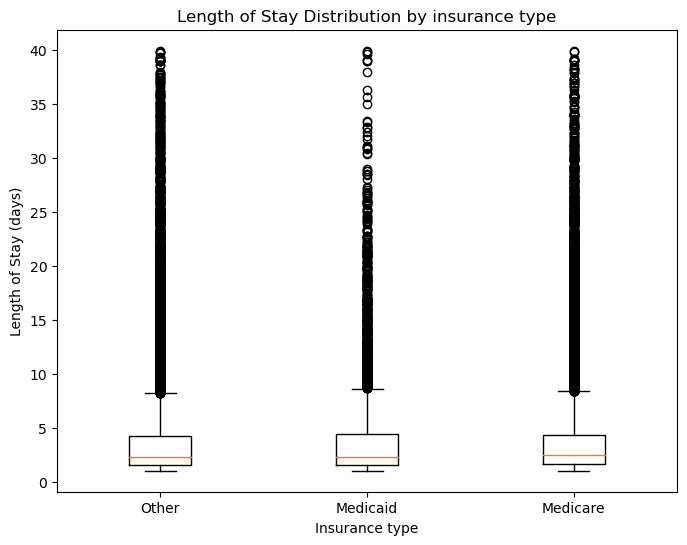

In [95]:
Other_los = icuStays.loc[icuStays['subject_id'].isin(admissions.loc[admissions['insurance'] == 'Other', 'subject_id']), 'los']
Medicaid_los = icuStays.loc[icuStays['subject_id'].isin(admissions.loc[admissions['insurance'] == 'Medicaid', 'subject_id']), 'los']
Medicare_los = icuStays.loc[icuStays['subject_id'].isin(admissions.loc[admissions['insurance'] == 'Medicare', 'subject_id']), 'los']

plt.figure(figsize=(8, 6))
plt.boxplot([Other_los, Medicaid_los, Medicare_los], labels=['Other', 'Medicaid', 'Medicare'])
plt.title('Length of Stay Distribution by insurance type')
plt.xlabel('Insurance type')
plt.ylabel('Length of Stay (days)')
plt.show()


# procedure --> corr analysis to see what is more important
# medications 24h

# 2000

In [96]:
other_median = np.median(Other_los)
medicaid_median = np.median(Medicaid_los)
medicair_median = np.median(Medicare_los)


print("Other:", other_median)
print("Medicaid:", medicaid_median)
print("Medicair:", medicair_median)

Other: 2.2875289351851853
Medicaid: 2.296070601851852
Medicair: 2.4591435185185184


### 3. Ethnicity-based

In [65]:
admissions['grouped_race'].unique()

array(['White', 'Other', 'Black/African American', 'Asian',
       'Hispanic/Latino'], dtype=object)

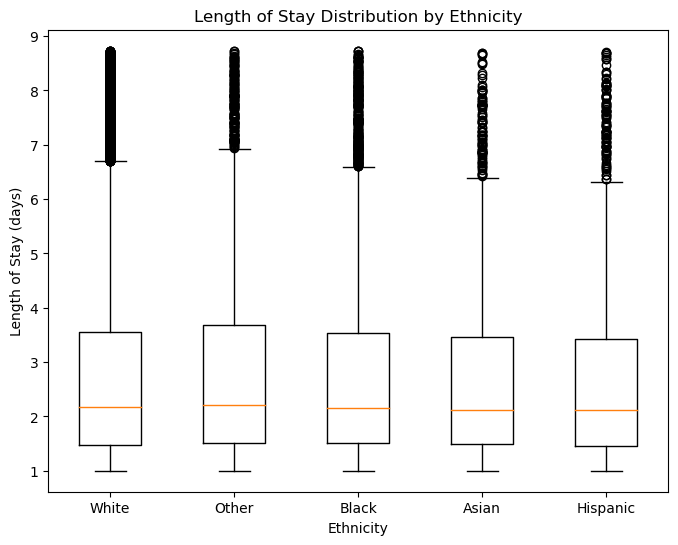

In [66]:
white_los = icuStays_clean.loc[icuStays_clean['subject_id'].isin(admissions.loc[admissions['grouped_race'] == 'White', 'subject_id']), 'los']
other_los = icuStays_clean.loc[icuStays_clean['subject_id'].isin(admissions.loc[admissions['grouped_race'] == 'Other', 'subject_id']), 'los']
black_los = icuStays_clean.loc[icuStays_clean['subject_id'].isin(admissions.loc[admissions['grouped_race'] == 'Black/African American', 'subject_id']), 'los']
asian_los = icuStays_clean.loc[icuStays_clean['subject_id'].isin(admissions.loc[admissions['grouped_race'] == 'Asian', 'subject_id']), 'los']
hispanic_los = icuStays_clean.loc[icuStays_clean['subject_id'].isin(admissions.loc[admissions['grouped_race'] == 'Hispanic/Latino', 'subject_id']), 'los']

plt.figure(figsize=(8, 6))
plt.boxplot([white_los, other_los, black_los, asian_los, hispanic_los], labels=['White', 'Other', 'Black', 'Asian', 'Hispanic'])
plt.title('Length of Stay Distribution by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Length of Stay (days)')
plt.show()

In [67]:
white_median = np.median(white_los)
other_median = np.median(other_los)
black_median = np.median(black_los)
asian_median = np.median(asian_los)
hispanic_median = np.median(hispanic_los)

print("White:", white_median)
print("Other:", other_median)
print("Black:", black_median)
print("Asian:", asian_median)
print("Hispanic:", hispanic_median)

White: 2.17275462962963
Other: 2.204415509259259
Black: 2.1625752314814815
Asian: 2.1208564814814816
Hispanic: 2.113130787037037


### 3. Age-based

In [56]:
patients.head()

,subject_id,gender,anchor_year,anchor_year_group,dod,ageG_18-24,ageG_25-44,ageG_45-64,ageG_65-88,ageG_89+
0,10000032,F,2180,2014 - 2016,2180-09-09,0,0,1,0,0
1,10000048,F,2126,2008 - 2010,NaN,1,0,0,0,0
2,10000068,F,2160,2008 - 2010,NaN,1,0,0,0,0
3,10000084,M,2160,2017 - 2019,2161-02-13,0,0,0,1,0
4,10000102,F,2136,2008 - 2010,NaN,0,1,0,0,0


# Filter the df's such that they can be used for modelling

### 1. only keep patients records in the 'patients' df that were admitted into ICU

In [66]:
augmented_df.shape

(48808, 29)

In [91]:
# Step 1: Create a combined key of subject_id and hadm_id in both DataFrames
icuStays['combined_key'] = icuStays['subject_id'].astype(str) + '_' + icuStays['hadm_id'].astype(str)
diagnoses['combined_key'] = diagnoses['subject_id'].astype(str) + '_' + diagnoses['hadm_id'].astype(str)

# Step 2: Find common combined keys
common_keys = set(icuStays['combined_key']).intersection(set(diagnoses['combined_key']))

# Step 3: Filter both DataFrames to keep only rows with the common combined keys
icuStays_filtered = icuStays[icuStays['combined_key'].isin(common_keys)]
diagnoses_filtered = diagnoses[diagnoses['combined_key'].isin(common_keys)]

# Step 4: Drop the combined_key column as it's no longer needed
icuStays_filtered.drop(columns=['combined_key'], inplace=True)
diagnoses_filtered.drop(columns=['combined_key'], inplace=True)

print(icuStays_filtered.shape)
print(diagnoses_filtered.shape)



(64, 8)
(63, 23)


/var/folders/8m/xsxvn0ns46dg_dpnlhpkxk6r0000gn/T/ipykernel_9430/128402073.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icuStays_filtered.drop(columns=['combined_key'], inplace=True)
/var/folders/8m/xsxvn0ns46dg_dpnlhpkxk6r0000gn/T/ipykernel_9430/128402073.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnoses_filtered.drop(columns=['combined_key'], inplace=True)


In [93]:
# Make one big df with all needed attributes
def data_cleaning_prep(icuStays, admissions, patients, diagnoses_count, diagnoses):

    # Columns to add from admissions DataFrame
    cols_to_add = ['subject_id', 'hadm_id', 'admission_location', 'discharge_location', 'admission_type', 'insurance', 'language', 'marital_status', 'race', 'raceGroup_1', 'raceGroup_2']

    # Merge admissions DataFrame with only the selected columns
    admissions_selected = admissions[cols_to_add]

    # Merge selected columns from admissions to icuStays based on subject_id and hadm_id
    merged_df = pd.merge(icuStays, admissions_selected, on=['subject_id', 'hadm_id'], how='left')

    # Add other protected attributes
    merged_df['gender'] = merged_df['subject_id'].map(patients.set_index('subject_id')['gender'])

    # Merge diagnoses_count DataFrame on subject_id and hadm_id + the diagnoses chapter
    merged_df = pd.merge(merged_df, diagnoses_count, on=['hadm_id'], how='left')

    #diagnoses.drop('subject_id', axis=1, inplace=True)
    merged_df = pd.merge(icuStays, diagnoses, on=['subject_id', 'hadm_id'], how='inner')

    # Filter out entries with non-unique hadm_id values
    non_unique_hadm_ids = merged_df['hadm_id'][merged_df['hadm_id'].duplicated()]
    merged_df = merged_df[~merged_df['hadm_id'].isin(non_unique_hadm_ids)]



    return merged_df


augmented_df = data_cleaning_prep(icuStays, admissions, patients, diagnoses_count, diagnoses)
print(augmented_df.shape)
augmented_df.head()


(62, 31)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,combined_key_x,Blood,...,Mental,Musculoskeletal,Neoplasms,Nervous,Perinatal,Pregnancy,Respiratory,Skin,Symptoms,combined_key_y
0,10195266,24940729,36629096,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2166-10-20 19:39:00,2166-10-21 20:34:37,1.038623,10195266_24940729,0,...,0,0,0,0,0,0,0,0,0,10195266_24940729
1,10435225,21805406,39207665,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2186-08-26 03:16:00,2186-08-27 12:56:13,1.402928,10435225_21805406,0,...,0,1,0,0,0,0,0,0,0,10435225_21805406
2,10486503,24479380,34105807,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2162-02-24 12:41:51,2162-02-25 14:12:38,1.063044,10486503_24479380,0,...,0,0,0,0,0,0,0,0,0,10486503_24479380
3,10501308,20658471,30405182,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2122-04-29 17:25:00,2122-04-30 17:54:26,1.020440,10501308_20658471,0,...,0,0,0,1,0,0,0,0,0,10501308_20658471
4,10720527,28521154,37968896,Neuro Intermediate,Neuro Intermediate,2122-06-16 11:44:15,2122-06-18 15:52:23,2.172315,10720527_28521154,0,...,0,0,0,0,0,0,0,0,0,10720527_28521154


In [59]:
augmented_df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'Blood', 'Circulatory', 'Congenital',
       'Digestive', 'Ear', 'Endocrine', 'External', 'Eye', 'Genitourinary',
       'Health', 'Infections', 'Injury', 'Mental', 'Musculoskeletal',
       'Neoplasms', 'Nervous', 'Perinatal', 'Pregnancy', 'Respiratory', 'Skin',
       'Symptoms'],
      dtype='object')

# Further preprocessing grouping of entries

In [146]:
augmented_df['admission_location'].unique()

array(['EMERGENCY ROOM', 'PACU', 'PHYSICIAN REFERRAL', 'PROCEDURE SITE',
       'TRANSFER FROM HOSPITAL', nan,
       'TRANSFER FROM SKILLED NURSING FACILITY',
       'INFORMATION NOT AVAILABLE', 'WALK-IN/SELF REFERRAL',
       'CLINIC REFERRAL', 'AMBULATORY SURGERY TRANSFER',
       'INTERNAL TRANSFER TO OR FROM PSYCH'], dtype=object)

In [147]:
num_nan_admission_location = augmented_df['admission_location'].isna().sum()
print("Number of NaN values in 'admission_location':", num_nan_admission_location)


Number of NaN values in 'admission_location': 5007


In [31]:
non_unique_hadm_ids = augmented_df['hadm_id'][augmented_df['hadm_id'].duplicated()]
non_unique_entries = augmented_df[augmented_df['hadm_id'].isin(non_unique_hadm_ids)]
print(len(non_unique_entries))
non_unique_entries.head()

0


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,Blood,Circulatory,...,Injury,Mental,Musculoskeletal,Neoplasms,Nervous,Perinatal,Pregnancy,Respiratory,Skin,Symptoms


In [51]:
# unique subject_id from the admissions df
admitted_subjectID = admissions['subject_id'].unique()

# update the patients df
print("Old shape of patients df: ", patients.shape)
patients = patients[patients['subject_id'].isin(admitted_subjectID)]
print("New shape of patients df: ", patients.shape)

Old shape of patients df:  (172409, 6)
New shape of patients df:  (172409, 6)


### 2. Store necessary data of patients into one big df

In [121]:
print(icuStays.shape)
icuStays.head(1)

(57571, 8)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032


In [122]:
print(admissions.shape)

admissions.head(1)

(418960, 18)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,raceGroup_1,raceGroup_2
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,White,NonMinority


In [124]:
icu_stays_hadm_ids = set(icuStays['subject_id'].unique())
admissions_hadm_ids = set(admissions['subject_id'].unique())

# Find the common 'hadm_id' using intersection
common_hadm_ids = icu_stays_hadm_ids.intersection(admissions_hadm_ids)

# Print the number of common 'hadm_id'
print("Number of common 'hadm_id':", len(common_hadm_ids))

Number of common 'hadm_id': 37413


In [120]:
# Merge admissions and icuStays on subject_id and hadm_id
merged_df = pd.merge(icuStays, admissions, on=['subject_id', 'hadm_id'], how='left')

# Convert 'admittime' and 'intime' to datetime objects
merged_df['admittime'] = pd.to_datetime(merged_df['admittime']).dt.date
merged_df['intime'] = pd.to_datetime(merged_df['intime']).dt.date

# Check if the admission date is the same as the intime date
merged_df = merged_df[merged_df['admittime'] == merged_df['intime']]

# Select the columns to add from admissions
cols_to_add = ['admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'raceGroup_1', 'raceGroup_2']

# Loop through the columns and add them to icuStays if they're not already present
for col in cols_to_add:
    if col not in merged_df.columns:
        merged_df[col] = merged_df[col]

# Display the updated DataFrame
print(merged_df.shape)
merged_df.head()


(32243, 24)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,raceGroup_1,raceGroup_2
1,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11,2110-04-12 23:59:56,1.338588,2110-04-11,2110-04-14 15:00:00,...,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0.0,White,NonMinority
3,10002013,23581541,39060235,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2160-05-18,2160-05-19 17:33:33,1.314352,2160-05-18,2160-05-23 13:30:00,...,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,OTHER,NaN,NaN,0.0,Other,Minority
4,10002155,23822395,33685454,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2129-08-04,2129-08-10 17:02:38,6.178912,2129-08-04,2129-08-18 16:53:00,...,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,MARRIED,WHITE,2129-08-04 11:00:00,2129-08-04 12:35:00,0.0,White,NonMinority
6,10002348,22725460,32610785,Neuro Intermediate,Neuro Intermediate,2112-11-30,2112-12-10 18:25:13,9.792512,2112-11-30,2112-12-10 17:56:00,...,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,2112-11-30 15:08:00,2112-11-30 23:24:00,0.0,White,NonMinority
7,10002428,20321825,34807493,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-30,2156-05-02 22:27:20,2.023843,2156-04-30,2156-05-03 16:36:00,...,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-30 18:30:00,2156-04-30 21:53:00,0.0,White,NonMinority


In [102]:
icuStays.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los'],
      dtype='object')

In [103]:
admissions.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'raceGroup_1',
       'raceGroup_2'],
      dtype='object')

In [126]:
# Add other protected attributes
merged_df['gender'] = merged_df['subject_id'].map(patients.set_index('subject_id')['gender'])
merged_df['anchor_age'] = merged_df['subject_id'].map(patients.set_index('subject_id')['anchor_age'])
merged_df['dod'] = merged_df['subject_id'].map(patients.set_index('subject_id')['dod'])


In [127]:
# add num of diagnoses too
merged_df = pd.merge(merged_df, diagnoses_count, on=['subject_id', 'hadm_id'], how='left')
merged_df.head(25)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admission_location,discharge_location,insurance,language,marital_status,race,raceGroup_1,raceGroup_2,gender,anchor_age,dod,diagnoses_count
0,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,EMERGENCY ROOM,HOME HEALTH CARE,Other,?,MARRIED,WHITE,White,NonMinority,F,55,NaN,10.0
1,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,PACU,HOME,Other,ENGLISH,MARRIED,WHITE,White,NonMinority,F,46,NaN,18.0
2,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,EMERGENCY ROOM,DIED,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,Black/African American,Minority,F,68,2131-01-20,36.0
3,10002013,23581541,39060235,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,OTHER,Other,Minority,F,53,NaN,22.0
4,10002155,23822395,33685454,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,PROCEDURE SITE,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,MARRIED,WHITE,White,NonMinority,F,80,2131-03-10,20.0
5,10002155,28994087,31090461,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2130-09-24 00:50:00,2130-09-27 22:13:41,3.891447,EMERGENCY ROOM,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,White,NonMinority,F,80,2131-03-10,15.0
6,10002348,22725460,32610785,Neuro Intermediate,Neuro Intermediate,2112-11-30 23:24:00,2112-12-10 18:25:13,9.792512,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,White,NonMinority,F,77,NaN,19.0
7,10002428,20321825,34807493,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-30 21:53:00,2156-05-02 22:27:20,2.023843,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,White,NonMinority,F,80,NaN,15.0
8,10002428,23473524,35479615,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),2156-05-11 14:49:34,2156-05-22 14:16:46,10.977222,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,White,NonMinority,F,80,NaN,18.0
9,10002428,28662225,33987268,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,White,NonMinority,F,80,NaN,34.0


In [119]:
merged_df.head()


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admission_location,discharge_location,insurance,language,marital_status,race,raceGroup_1,raceGroup_2,diagnoses_count_x,diagnoses_count_y
0,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,EMERGENCY ROOM,HOME HEALTH CARE,Other,?,MARRIED,WHITE,White,NonMinority,10.0,10.0
1,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,PACU,HOME,Other,ENGLISH,MARRIED,WHITE,White,NonMinority,18.0,18.0
2,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,EMERGENCY ROOM,DIED,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,Black/African American,Minority,36.0,36.0
3,10002013,23581541,39060235,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,OTHER,Other,Minority,22.0,22.0
4,10002155,23822395,33685454,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,PROCEDURE SITE,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,MARRIED,WHITE,White,NonMinority,20.0,20.0


In [72]:
print(merged_df.shape)
len(merged_df['hadm_id'].unique())

(32243, 27)


32243

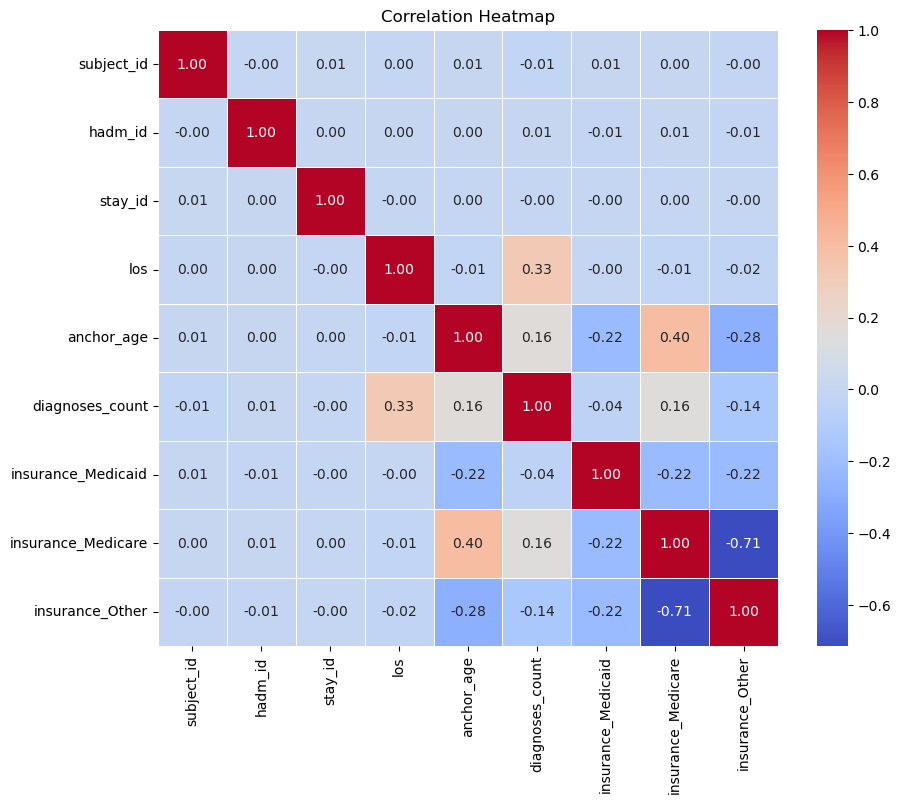

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = merged_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()



In [ ]:
# INSPO: https://github.com/daniel-codes/hospital-los-predictor/blob/fccda3cd0c77309bccda1230a09d36b64cf038ed/hospital_los_prediction.ipynb 

# https://github.com/akakadiaris/FairnessofMIMICIV/blob/main/Code_NoImputation.ipynb 